<a href="https://colab.research.google.com/github/sarahfirouzabadi/Summer-2025-ECE-597-Group5/blob/main/Only_CEAS_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from scipy.sparse import hstack, csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
TFIDV=TfidfVectorizer()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
CEAS=pd.read_csv('/CEAS_08.csv')
CEAS.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [ ]:
label_counts = CEAS['label'].value_counts().sort_index()
num_ham = label_counts.get(0, 0)
num_spam = label_counts.get(1, 0)

print(f"CEAS:\nHam: {num_ham}\nSpam: {num_spam}")

CEAS:
Ham: 17312
Spam: 21842


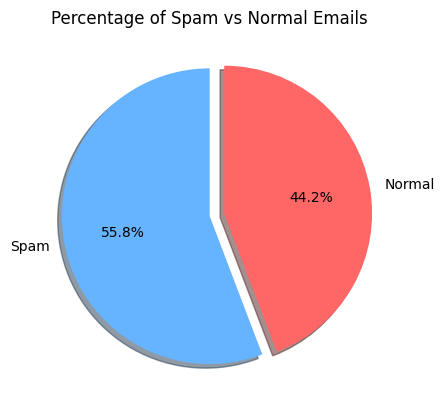

In [ ]:
email_counts = CEAS['label'].value_counts().rename({0: 'Normal', 1: 'Spam'})

email_counts.plot.pie(
    autopct='%1.1f%%',
    colors=['#66b3ff','#ff6666'],
    startangle=90,
    explode=(0, 0.1),
    shadow=True
)

plt.title('Percentage of Spam vs Normal Emails')
plt.ylabel('')  # remove default y-axis label

plt.show()

In [ ]:
# Use CEAS only
df = CEAS.copy()
df.drop_duplicates(subset=['sender', 'subject', 'body'], inplace=True)
df.dropna(subset=['sender', 'subject', 'body'], inplace=True)

df.reset_index(drop=True, inplace=True)
print(f'\nCleaned CEAS dataset shape: {df.shape}')


Cleaned CEAS dataset shape: (39126, 7)


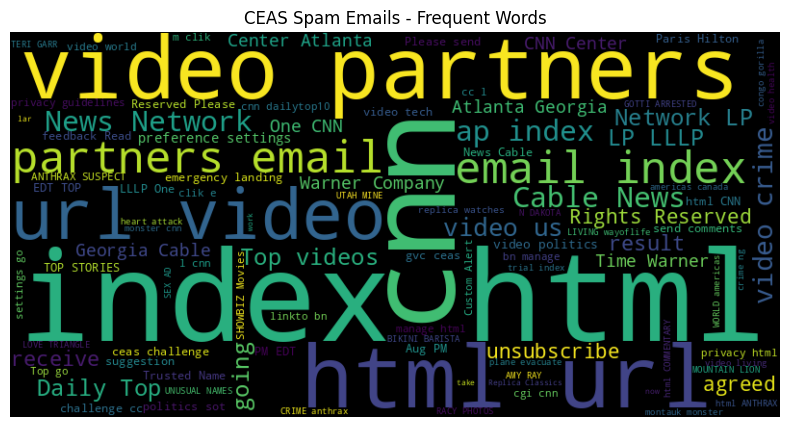


Top 50 frequent words in CEAS spam emails:
cnn: 110176
com: 95992
http: 82588
www: 69360
html: 65167
video: 59832
index: 59277
email: 35464
url: 29505
partners: 29325
crime: 15596
top: 15192
us: 13908
news: 12759
ap: 8942
network: 8718
settings: 8677
cable: 8673
world: 7781
privacy: 7353
manage: 7275
politics: 6879
obama: 6854
go: 6271
time: 6241
going: 5988
videos: 5928
daily: 5900
lp: 5894
stories: 5862
lllp: 5860
one: 5726
replica: 5666
alert: 5628
aug: 5520
trial: 4950
living: 4945
health: 4943
attack: 4894
mom: 4878
anthrax: 4860
suspect: 4836
receive: 4720
company: 4689
name: 4615
center: 4444
unsubscribe: 4433
result: 4374
agreed: 4371
reserved: 4359

Top 50 frequent words in CEAS normal emails:
submission: 52420
http: 45691
com: 39712
id: 38589
org: 33148
python: 32562
added: 19659
sender: 18953
notes: 18411
mail: 17617
www: 17537
virus: 17236
list: 15527
total: 14771
wrote: 13486
message: 12608
new: 12360
one: 10718
use: 10702
would: 10136
e: 9680
university: 9144
like: 9113


In [ ]:
# Word cloud for spam emails in CEAS
spam_emails_ceas = df[df['label'] == 1]['body'].dropna()

if not spam_emails_ceas.empty:
    spam_words = ' '.join(spam_emails_ceas)
    wordcloud_spam = WordCloud(width=800, height=400, max_words=100).generate(spam_words)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.title('CEAS Spam Emails - Frequent Words')
    plt.axis('off')
    plt.show()
else:
    print("No spam emails to generate word cloud for in CEAS dataset.")

stop_words = set(stopwords.words('english'))

word_counter_spam = Counter()
word_counter_normal = Counter()


for index, row in df.iterrows():
    text = row['body']
    label = row['label']
    if pd.isna(text):
      continue # Skip if body is NaN

    words = re.findall(r'\b[a-z]+\b', str(text).lower())
    filtered_words = [word for word in words if word not in stop_words]

    if label == 1:
        word_counter_spam.update(filtered_words)
    else:
        word_counter_normal.update(filtered_words)

print("\nTop 50 frequent words in CEAS spam emails:")
for word, freq in word_counter_spam.most_common(50):
    print(f"{word}: {freq}")

print("\nTop 50 frequent words in CEAS normal emails:")
for word, freq in word_counter_normal.most_common(50):
    print(f"{word}: {freq}")



Average words per CEAS spam email: 90.69
Total unique words in CEAS spam emails: 37690
Average words per CEAS normal email: 223.50
Total unique words in CEAS normal emails: 87354

Top 20 words most indicative of CEAS spam:
cnn: 110176
com: 95992
http: 82588
www: 69360
html: 65167
video: 59832
index: 59277
email: 35464
url: 29505
partners: 29325
crime: 15596
top: 15192
us: 13908
news: 12759
ap: 8942
network: 8718
settings: 8677
cable: 8673
world: 7781
privacy: 7353


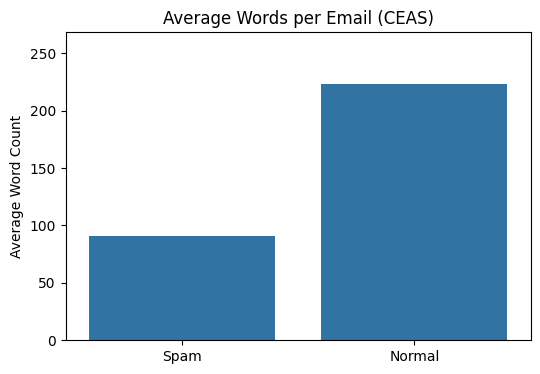

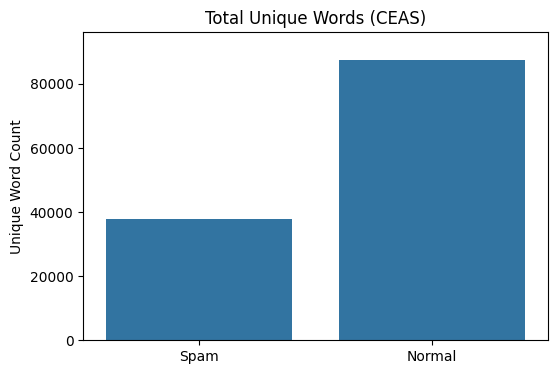

In [ ]:
# Tokenization and word statistics
def tokenize(text):
    text = str(text).lower()
    words = re.findall(r'\b[a-z]+\b', text)
    return [w for w in words if w not in stop_words]

df['tokens'] = df['body'].apply(tokenize)

spam_tokens = df[df['label'] == 1]['tokens']
normal_tokens = df[df['label'] == 0]['tokens']

if not spam_tokens.empty:
    avg_words_spam = spam_tokens.apply(len).mean()
    flat_spam = [word for tokens in spam_tokens for word in tokens]
    unique_spam = len(set(flat_spam))
    print(f"\nAverage words per CEAS spam email: {avg_words_spam:.2f}")
    print(f"Total unique words in CEAS spam emails: {unique_spam}")
else:
    print("\nNo spam emails in CEAS to calculate average words or unique words.")

if not normal_tokens.empty:
    avg_words_normal = normal_tokens.apply(len).mean()
    flat_normal = [word for tokens in normal_tokens for word in tokens]
    unique_normal = len(set(flat_normal))
    print(f"Average words per CEAS normal email: {avg_words_normal:.2f}")
    print(f"Total unique words in CEAS normal emails: {unique_normal}")
else:
    print("No normal emails in CEAS to calculate average words or unique words.")


# Most indicative spam words
if not spam_tokens.empty and not normal_tokens.empty:
    spam_counter = Counter(flat_spam)
    normal_counter = Counter(flat_normal)

    # Words more frequent in spam than normal (considering a minimum frequency)
    indicative_spam = {
        word: freq for word, freq in spam_counter.items()
        if freq > normal_counter.get(word, 0) # and freq > 5 # Optional: add threshold
    }

    top_indicative = Counter(indicative_spam).most_common(20)

    print("\nTop 20 words most indicative of CEAS spam:")
    if top_indicative:
        for word, freq in top_indicative:
            print(f"{word}: {freq}")
    else:
        print("No words found that are more indicative of spam than normal.")
else:
    print("\nCannot determine indicative words without both spam and normal emails.")


# Plot average words
if 'avg_words_spam' in locals() and 'avg_words_normal' in locals():
    avg_words_data = {'Spam': avg_words_spam, 'Normal': avg_words_normal}

    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(avg_words_data.keys()), y=list(avg_words_data.values()))
    plt.title('Average Words per Email (CEAS)')
    plt.ylabel('Average Word Count')
    plt.ylim(0, max(avg_words_data.values()) * 1.2)
    plt.show()

# Plot unique words
if 'unique_spam' in locals() and 'unique_normal' in locals():
    unique_words_data = {'Spam': unique_spam, 'Normal': unique_normal}

    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(unique_words_data.keys()), y=list(unique_words_data.values()))
    plt.title('Total Unique Words (CEAS)')
    plt.ylabel('Unique Word Count')
    plt.ylim(0, max(unique_words_data.values()) * 1.1)
    plt.show()

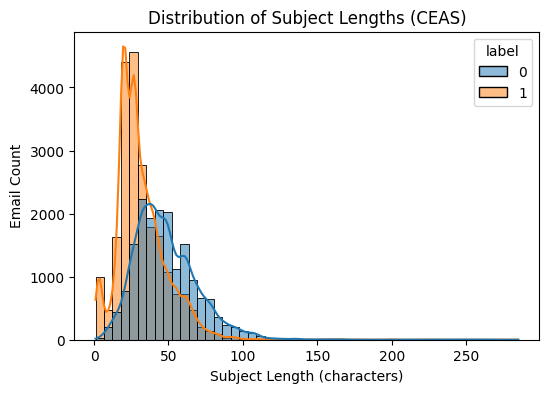


Average subject length - CEAS Spam: 31.63
Average subject length - CEAS Normal: 48.13


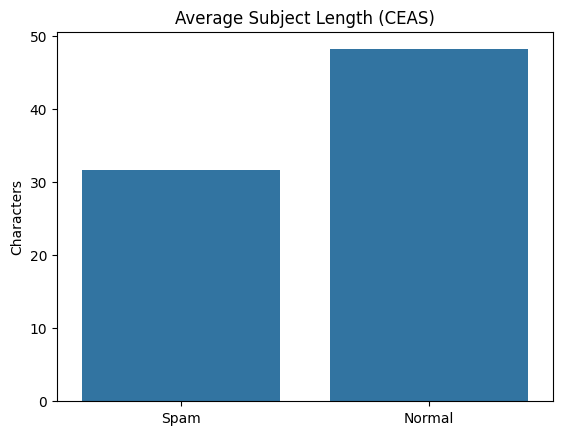

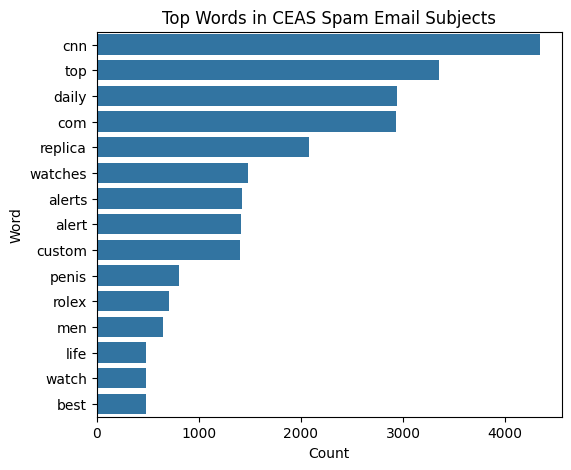

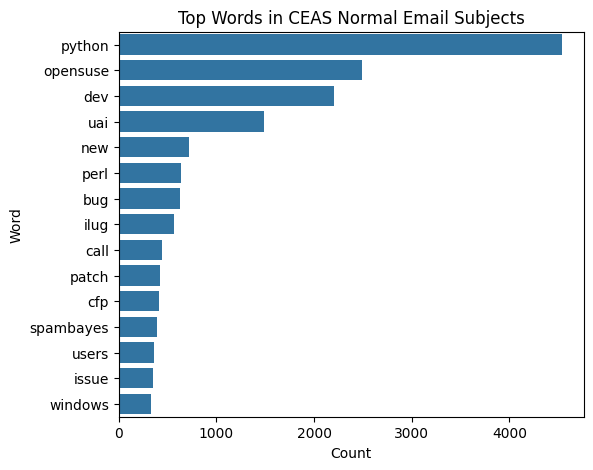

In [ ]:
# Subject analysis
df['subject_length'] = df['subject'].fillna('').apply(len)

plt.figure(figsize=(6,4))
sns.histplot(data=df, x='subject_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Subject Lengths (CEAS)')
plt.xlabel('Subject Length (characters)')
plt.ylabel('Email Count')
plt.show()


avg_len_spam_subject = df[df['label'] == 1]['subject_length'].mean()
avg_len_normal_subject = df[df['label'] == 0]['subject_length'].mean()

print(f"\nAverage subject length - CEAS Spam: {avg_len_spam_subject:.2f}")
print(f"Average subject length - CEAS Normal: {avg_len_normal_subject:.2f}")

sns.barplot(x=['Spam', 'Normal'], y=[avg_len_spam_subject, avg_len_normal_subject])
plt.title('Average Subject Length (CEAS)')
plt.ylabel('Characters')
plt.show()

# Top words in subjects
stop_words = set(stopwords.words('english'))

def clean_subject(text):
    words = re.findall(r'\b[a-z]+\b', str(text).lower())
    return [w for w in words if w not in stop_words]

spam_subject_words = df[df['label'] == 1]['subject'].dropna().apply(clean_subject)
normal_subject_words = df[df['label'] == 0]['subject'].dropna().apply(clean_subject)

spam_subject_flat = [word for words in spam_subject_words for word in words]
normal_subject_flat = [word for words in normal_subject_words for word in words]

spam_top_subject = Counter(spam_subject_flat).most_common(15)
normal_top_subject = Counter(normal_subject_flat).most_common(15)

if spam_top_subject:
    df_spam_subject = pd.DataFrame(spam_top_subject, columns=['Word', 'Count'])
    plt.figure(figsize=(6, 5))
    sns.barplot(data=df_spam_subject, y='Word', x='Count')
    plt.title('Top Words in CEAS Spam Email Subjects')
    plt.show()
else:
    print("No common words found in CEAS spam subjects.")

if normal_top_subject:
    df_normal_subject = pd.DataFrame(normal_top_subject, columns=['Word', 'Count'])
    plt.figure(figsize=(6, 5))
    sns.barplot(data=df_normal_subject, y='Word', x='Count')
    plt.title('Top Words in CEAS Normal Email Subjects')
    plt.show()
else:
    print("No common words found in CEAS normal subjects.")

In [ ]:
# Extracting the Domain
df["sender_domain"]=df['sender'].fillna('').str.split('@').str[1]
print("\nSender Domain Value Counts (CEAS):")
print(df["sender_domain"].value_counts().head())


Sender Domain Value Counts (CEAS):
sender_domain
gmail.com>           2625
python.org>           527
issues.apache.org     462
v.loewis.de>          289
google.com>           239
Name: count, dtype: int64


In [ ]:
# Data cleaning and tokenization for modeling
def clean_and_tokenize(text):
    text = str(text).lower()                             # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)                 # Remove punctuation and numbers
    tokens = text.split()                                # Tokenize by whitespace
    tokens = [t for t in tokens if t not in stop_words]  # Remove stopwords
    return tokens

df['body_tokens'] = df['body'].fillna('').apply(clean_and_tokenize)
df['subject_tokens'] = df['subject'].fillna('').apply(clean_and_tokenize)

print("\nSample cleaned body (CEAS):", df['body_tokens'].iloc[0])
print("Sample cleaned subject (CEAS):", df['subject_tokens'].iloc[0])

# Feature engineering
df['email_length'] = df['body'].fillna('').str.len()
df['subject_length'] = df['subject'].fillna('').str.len()
df['body_word_count'] = df['body_tokens'].apply(len)
df['subject_word_count'] = df['subject_tokens'].apply(len)

url_pattern = r'(https?://[^\s]+)'
df['num_urls'] = df['body'].fillna('').apply(lambda x: len(re.findall(url_pattern, x)))

df['sender_domain_clean'] = df['sender_domain'].fillna('')


print("\nPreview engineered features (CEAS):")
print(df[['email_length', 'subject_length', 'body_word_count', 'subject_word_count',
          'num_urls', 'sender_domain']].head())

# TF-IDF
df['body_clean'] = df['body_tokens'].apply(lambda x: ' '.join(x))
df['subject_clean'] = df['subject_tokens'].apply(lambda x: ' '.join(x))


# Re-initialize TF-IDF vectorizers if needed, or ensure they are fit on CEAS data
tfidf_body = TfidfVectorizer(stop_words='english', max_features=3000)
X_body = tfidf_body.fit_transform(df['body_clean'])

tfidf_subject = TfidfVectorizer(stop_words='english', max_features=1000)
X_subject = tfidf_subject.fit_transform(df['subject_clean'])

tfidf_sender = TfidfVectorizer()
X_sender = tfidf_sender.fit_transform(df['sender_domain_clean'])


print("\nTF-IDF shape (body, CEAS):", X_body.shape)
print("TF-IDF shape (subject, CEAS):", X_subject.shape)
print("TF-IDF shape (sender, CEAS):", X_sender.shape)


Sample cleaned body (CEAS): ['buck', 'troubles', 'caused', 'small', 'dimension', 'soon', 'become', 'lover', 'woman', 'able', 'resist', 'httpwhitedonecom', 'come', 'even', 'nazi', 'tanks', 'rolling', 'streets', 'dreamersphilosopher', 'journalist', 'still', 'surei']
Sample cleaned subject (CEAS): ['never', 'agree', 'loser']

Preview engineered features (CEAS):
   email_length  subject_length  body_word_count  subject_word_count  \
0           273              25               22                   3   
1            82              22                5                   3   
2          3918              20              182                   3   
3         24418             150             1650                   7   
4           175              26                2                   1   

   num_urls         sender_domain  
0         1            iworld.de>  
1         1            icable.ph>  
2        24  universalnet.psi.br>  
3       467            pobox.com>  
4         1  loanofficert

In [ ]:
# Prepare data for modeling
y = df['label']

numeric_cols = [
    'email_length',
    'subject_length',
    'body_word_count',
    'subject_word_count',
    'num_urls'
]
X_numeric_raw = df[numeric_cols].fillna(0)

scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric_raw)


X_all = hstack([
    X_body,
    X_subject,
    X_sender,
    csr_matrix(X_numeric)
])


X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y # stratify is good practice with imbalanced data, even without downsampling
)

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train label distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test label distribution:\n{y_test.value_counts(normalize=True)}")


Train shape: (31300, 21624), Test shape: (7826, 21624)
Train label distribution:
label
1    0.557923
0    0.442077
Name: proportion, dtype: float64
Test label distribution:
label
1    0.557884
0    0.442116
Name: proportion, dtype: float64



Logistic Regression (CEAS):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3460
           1       0.99      1.00      0.99      4366

    accuracy                           0.99      7826
   macro avg       0.99      0.99      0.99      7826
weighted avg       0.99      0.99      0.99      7826

ROC AUC Score: 0.999770626411657


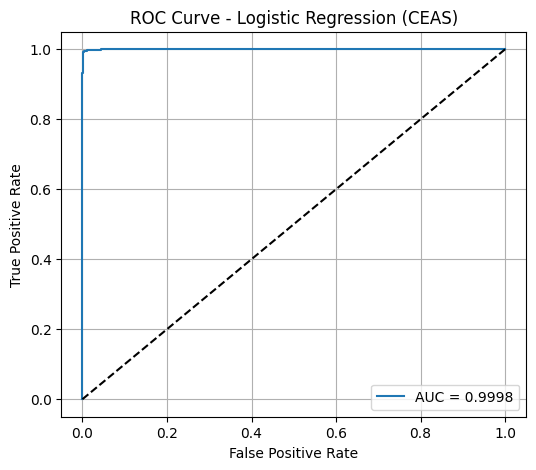

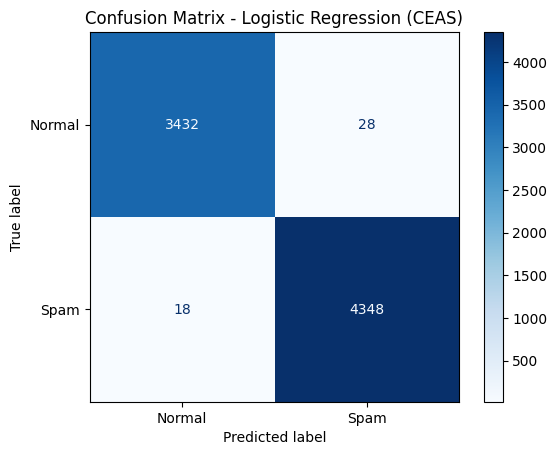

In [ ]:
# Logistic Regression:

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Evaluating
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

print("\nLogistic Regression (CEAS):")
print(classification_report(y_test, y_pred_log))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_log))

# ROC for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
auc_log = roc_auc_score(y_test, y_proba_log)

plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, label=f'AUC = {auc_log:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (CEAS)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion matrix for Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)

disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=["Normal", "Spam"])
disp_log.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Logistic Regression (CEAS)")
plt.grid(False)
plt.show()


Random Forest (CEAS):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3460
           1       1.00      0.99      1.00      4366

    accuracy                           1.00      7826
   macro avg       0.99      1.00      0.99      7826
weighted avg       1.00      1.00      1.00      7826

ROC AUC Score: 0.9996188360399197


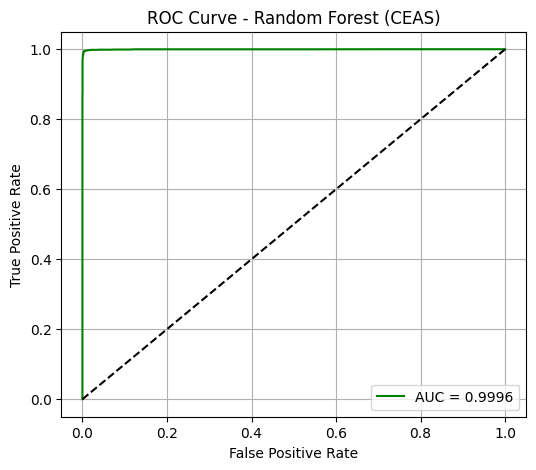

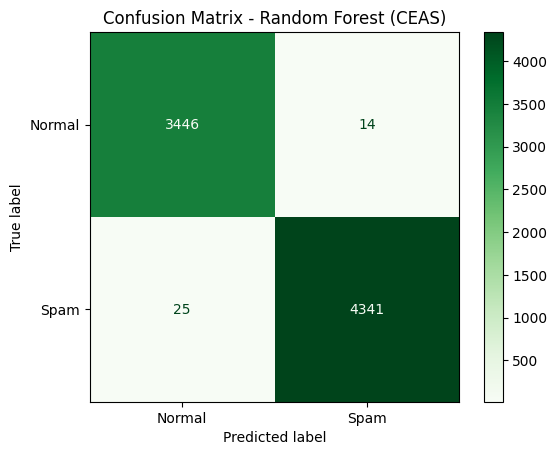

In [ ]:
# Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("\nRandom Forest (CEAS):")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))

# ROC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {auc_rf:.4f}', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (CEAS)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Normal", "Spam"])
disp_rf.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix - Random Forest (CEAS)")
plt.grid(False)
plt.show()

In [ ]:
# Comparison table
comparison_data = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_rf)],
    "ROC_AUC": [roc_auc_score(y_test, y_proba_log), roc_auc_score(y_test, y_proba_rf)],
}
print("\nModel Comparison (CEAS):")
print(pd.DataFrame(comparison_data))


Model Comparison (CEAS):
                 Model  Accuracy   ROC_AUC
0  Logistic Regression  0.994122  0.999771
1        Random Forest  0.995017  0.999619



Naive Bayes (CEAS):
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3460
           1       1.00      0.77      0.87      4366

    accuracy                           0.87      7826
   macro avg       0.89      0.88      0.87      7826
weighted avg       0.90      0.87      0.87      7826

ROC AUC Score: 0.8826293693517168


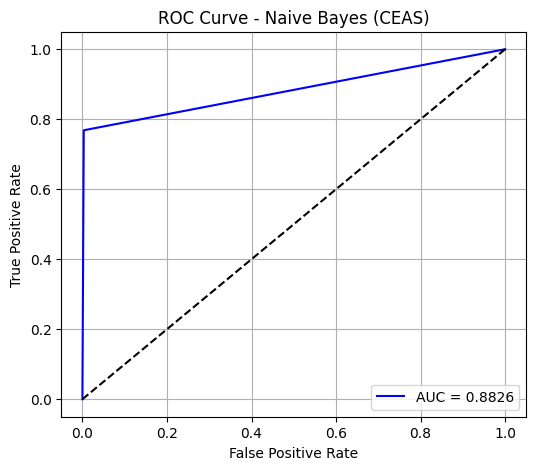

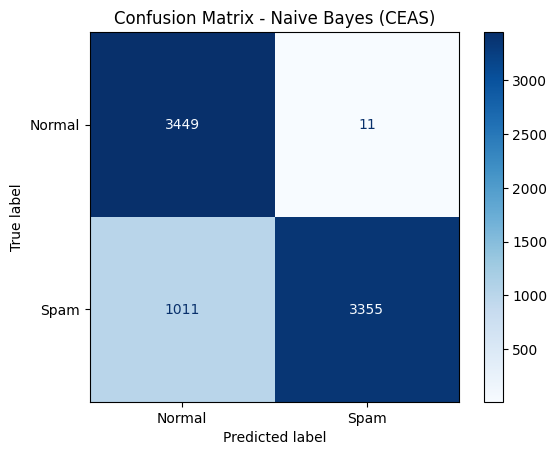

In [ ]:
# Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train.toarray(), y_train)  # Convert sparse matrix to dense

y_pred_nb = nb_model.predict(X_test.toarray())
y_proba_nb = nb_model.predict_proba(X_test.toarray())[:, 1]

print("\nNaive Bayes (CEAS):")
print(classification_report(y_test, y_pred_nb))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_nb))

# ROC
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
auc_nb = roc_auc_score(y_test, y_proba_nb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_nb, tpr_nb, label=f'AUC = {auc_nb:.4f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes (CEAS)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)

disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=["Normal", "Spam"])
disp_nb.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Naive Bayes (CEAS)")
plt.grid(False)
plt.show()

In [ ]:
comparison_data = {
    "Model": ["Logistic Regression", "Random Forest", "Naive Bayes"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_nb)
    ],
    "ROC_AUC": [
        roc_auc_score(y_test, y_proba_log),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_nb)
    ],
}
print("\nModel Comparison (CEAS):")
print(pd.DataFrame(comparison_data))


Model Comparison (CEAS):
                 Model  Accuracy   ROC_AUC
0  Logistic Regression  0.994122  0.999771
1        Random Forest  0.995017  0.999619
2          Naive Bayes  0.869410  0.882629


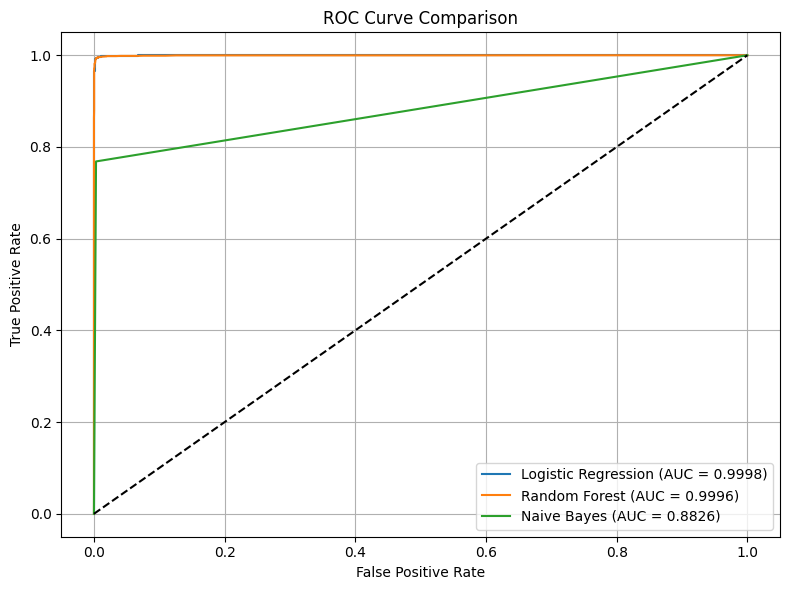

In [ ]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
auc_log = roc_auc_score(y_test, y_proba_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
auc_nb = roc_auc_score(y_test, y_proba_nb)

# Plot all three ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.4f})')

# Diagonal baseline
plt.plot([0, 1], [0, 1], 'k--')

# Labels and styling
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
